Author: Diana Rozenshteyn

https://towardsdatascience.com/daily-to-weekly-pandas-c0557b12f052

# Converting Daily Data to Weekly in Pandas. #

Hands-on tutorial for converting daily data to weekly

In this article  I will show 4 different methods for converting daily data to weekly in Pandas and compare their performance.

## The Challenge ##

Recently, in one of my graduate classes I was asked to evaluate Covid-19 daily cases in various counties in the United States over the last year using Pandas. The challenge was to present findings as a weekly, rather than daily data. As a beginner in using Pandas this simple task was daunting to me at first, but in the process of completing this assignment I have developed 4 different methods to convert daily data to weekly. 
 
The csv file used in this article is publicly available on [usafacts.org](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/) webpage.

In [19]:
import os
import numpy as np
import pandas as pd
import time

cases = pd.read_csv('covid_confirmed_usafacts.csv')

First, let’s get the cvs file ready to work on:

+ For simplicity of the output, we will only concentrate on total number of cases in four states: CA, OR, WA and NV. Therefore, not needed county and state identification columns can be dropped.

+ Week in our evaluation will start on Monday and end on Sunday. Thus, columns for dates corresponding to incomplete weeks in the beginning/end of the date range, can be dropped as well. For this publication the datafile used contains data from 01/22/2020 to 02/07/2021.

+ The data in the original csv file is a running total of Covid-19 cases and needs to be transformed to new cases. This is done by using sum() followed by diff() functions applied to dataframe grouped by State.

+ Finally, 01/26/2020 is a Sunday just before the first Monday in the dataframe and a part of the incomplete week. It must be dropped only after the new cases numbers calculated so new cases data is not lost for the first Monday.

In [20]:
cases_states = cases.query("State == 'CA' | State == 'OR' | State == 'WA' | State == 'NV'")
cases_states_filtered = cases_states.drop(columns = ['countyFIPS', 'StateFIPS','County Name', '2020-01-22', 
                                                     '2020-01-23', '2020-01-24', '2020-01-25'])
cases_states_daily_total = cases_states_filtered.groupby('State').sum()
new_cases_daily_total = cases_states_daily_total.diff(axis = 1)
new_cases_daily_total = new_cases_daily_total.drop(columns = ['2020-01-26'])
display(new_cases_daily_total)

,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,...,2021-01-29,2021-01-30,2021-01-31,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07
State,,,,,,,,,,,,,,,,,,,,,
CA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,19337.0,18427.0,18974.0,15358.0,12064.0,10501.0,13176.0,14021.0,12394.0,15064.0
NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2383.0,1058.0,948.0,819.0,0.0,1560.0,881.0,888.0,0.0,1533.0
OR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,947.0,0.0,0.0,1644.0,605.0,627.0,715.0,818.0,0.0,0.0
WA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1992.0,1796.0,0.0,1738.0,1357.0,1602.0,1584.0,1493.0,775.0,0.0


## Method 1: using Python for-loops.

As I have now learned, using Python for-loops to iterate over data in Pandas is not the most efficient way to go about converting daily data to weekly. Just looping with Python for-loops does not take any advantage of build-in functions Pandas has to offer and it is the slowest way to accomplish the task at hand. However, in the beginning of this journey for-loops seemed as the easiest way to convert daily data columns to weekly, so I started with implementing a function that does that.

Function new_case_count() takes in DataFrame object, iterates over it and converts indexes, which are dates in string format, to Pandas Datetime format. Based on the date's day of the week, each week's new cases count is calculated and stored in a list. The function returns a list of weekly new cases counts for each state.

For simplicity, output for this and other methods only shows last 5 weeks of data.

In [21]:
def new_case_count(state_new_cases):
    first_Monday_found = False
    week_case_count = 0
    week_case_counts = []
    for index, value in state_new_cases.items():
        index_date = pd.to_datetime(index, format='%Y/%m/%d', exact = False)
        index_day_of_week = index_date.day_name()
        if not first_Monday_found and index_day_of_week != 'Monday':
            continue
        first_Monday_found = True
        week_case_count += value
        if index_day_of_week == 'Sunday':
            week_case_counts.append(week_case_count)
            week_case_count = 0
    return week_case_counts

# converting list to DataFrame object
new_cases_weekly_total_method_1 = pd.DataFrame(new_case_count(new_cases_daily_total))

In [22]:
display(new_cases_weekly_total_method_1.tail(5))

State,CA,NV,OR,WA
2021-01-04,279701.0,16743.0,8939.0,8749.0
2021-01-11,271512.0,12797.0,8411.0,19780.0
2021-01-18,166676.0,9197.0,5581.0,16421.0
2021-01-25,134177.0,7338.0,4891.0,11399.0
2021-02-01,92578.0,5681.0,4409.0,8549.0


## Method 2: relabeling and groupby().

My next attempt at converting daily data to weekly does not involve any for-loops. However, it is still the second slowest method of the four. 

Function rename_columns_dates() takes in Series object and converts indexes, which are dates in string format, to Pandas Datetime format. The dates are relabeled with a date for current week's Monday in the '%Y/%m/%d' format followed by delimiter (% sign) and a number of days that the current date is offset from the current week's Monday. The function returns a string representing the new dates labelling. 
For example, for Monday 2021/01/25 the return string will be '2021/01/25%0', for Tuesday 2021/01/26 the return string will be '2021/01/25%1', and so on.

Next, new cases grouped weekly by splitting data labels at delimiter (%) and summing the values for the group that have the same Monday as their date.

In [23]:
def rename_columns_dates(new_cases_index):
    index_date = pd.to_datetime(new_cases_index, format='%Y/%m/%d', exact = False)
    index_day_of_week = index_date.day_name()
    offset_from_monday = 0
    if index_day_of_week == 'Tuesday':
        offset_from_monday = 1
    elif index_day_of_week == 'Wednesday':
        offset_from_monday = 2
    elif index_day_of_week == 'Thursday':
        offset_from_monday = 3
    elif index_day_of_week =='Friday':
        offset_from_monday = 4
    elif index_day_of_week == 'Saturday':
        offset_from_monday = 5
    elif index_day_of_week == 'Sunday':
        offset_from_monday = 6
        
    # new_date is a class of Pandas.Timeframe   
    new_date = index_date - pd.Timedelta(days = offset_from_monday)
    return (new_date.strftime('%Y/%m/%d') + '%' + str(offset_from_monday))


new_cases_weekly_total = new_cases_daily_total.rename(rename_columns_dates, axis = 'columns')

# grouping new cases weekly by splitting data labells at delimiter (%) and summing the values for the same Monday
new_cases_weekly_total_method_2 = new_cases_weekly_total.groupby(new_cases_weekly_total.columns.str.split('%').str[0], 
                                                        axis=1).sum()

In [24]:
display(new_cases_weekly_total_method_2.T.tail(5))

State,CA,NV,OR,WA
2021/01/04,279701.0,16743.0,8939.0,8749.0
2021/01/11,271512.0,12797.0,8411.0,19780.0
2021/01/18,166676.0,9197.0,5581.0,16421.0
2021/01/25,134177.0,7338.0,4891.0,11399.0
2021/02/01,92578.0,5681.0,4409.0,8549.0


## Method 3: resample().

This method uses a resample() function. I came across couple of articles on Medium [here](https://raj26kumar.medium.com/convert-daily-data-to-weekly-data-without-losing-names-of-other-column-using-python-pandas-e2aa001a3691) and [here](https://medium.com/@sharath.ravi/convert-daily-data-to-weekly-data-using-python-pandas-6c73abcfb5f7) on how to convert daily data to weekly with resample(). After making some changes to the dataframe I had this method up and running. 

It is the second fastest of the four as demonstrated at the end of this article. 

In [25]:
new_cases_daily_total_modified = new_cases_daily_total.T.reset_index()

new_cases_daily_total_modified = new_cases_daily_total_modified.assign(Weeks = 
                                                new_cases_daily_total_modified['index']).drop(columns = 'index')

new_cases_daily_total_modified['Weeks'] = new_cases_daily_total_modified['Weeks'].astype('datetime64[ns]')

new_cases_weekly_total_method_3 = new_cases_daily_total_modified.resample('W-Mon', label='left', 
                                                                          closed = 'left', on='Weeks').sum()

In [26]:
display(new_cases_weekly_total_method_3.tail(5))

State,CA,NV,OR,WA
Weeks,,,,
2021-01-04,279701.0,16743.0,8939.0,8749.0
2021-01-11,271512.0,12797.0,8411.0,19780.0
2021-01-18,166676.0,9197.0,5581.0,16421.0
2021-01-25,134177.0,7338.0,4891.0,11399.0
2021-02-01,92578.0,5681.0,4409.0,8549.0


## Method 4: groupby().

The idea for this method came to me after reading a suggestion on [stackoverflow](https://stackoverflow.com/questions/46607027/pandas-sum-of-every-n-columns). I was excited that you can group columns by 7 at a time in just one line. However, this simplicity comes at a price of losing your date labels and instead having numbers as indexes, 0-53 in this case. 

To fix this I came up with an idea of creating a date range that is needed by using pd.period_range() function, converting the date range to Series and adding it to the DataFrame that now has weekly data. The period_range() function returns a fixed frequency PeriodIndex. The date period in this format looks like this: 'Monday date/Sunday date'. You can keep that as is or split the string on delimiter ('/') to just have Monday date marking the start of the week. 

This method turned out to be the fastest method among the four tested.

In [27]:
new_cases_groupby_total_method_4 = new_cases_daily_total.groupby([[i//7 for i in range(0,378)]], axis = 1).sum().T

date_range = pd.period_range(start = '2020-01-27', end = '2021-02-07', freq = 'W-SUN')
date_range = date_range.map(str)
date_range = date_range.str.split('/').str[0]

date_range = pd.Series(date_range)

new_cases_weekly_total_method_4 = new_cases_groupby_total_method_4.assign(Weeks = date_range)

In [28]:
print('DataFrame after groupby():')
display(new_cases_groupby_total_method_4.tail(5))
print('\n')

print('date_range Series:')
display(date_range.tail(5))
print('\n')

print('Final Dataframe:')
display(new_cases_weekly_total_method_4.set_index(['Weeks']).tail(5))

DataFrame after groupby():


State,CA,NV,OR,WA
49,279701.0,16743.0,8939.0,8749.0
50,271512.0,12797.0,8411.0,19780.0
51,166676.0,9197.0,5581.0,16421.0
52,134177.0,7338.0,4891.0,11399.0
53,92578.0,5681.0,4409.0,8549.0




date_range Series:


49    2021-01-04
50    2021-01-11
51    2021-01-18
52    2021-01-25
53    2021-02-01
dtype: object



Final Dataframe:


State,CA,NV,OR,WA
Weeks,,,,
2021-01-04,279701.0,16743.0,8939.0,8749.0
2021-01-11,271512.0,12797.0,8411.0,19780.0
2021-01-18,166676.0,9197.0,5581.0,16421.0
2021-01-25,134177.0,7338.0,4891.0,11399.0
2021-02-01,92578.0,5681.0,4409.0,8549.0


## Performance evaluation:

Each method's execution time was measured. I used %%timeit to measure execution time on Jupyter Notebooks by placing %%timeit at the top of each method's cell. To compare the performance of these four methods I have run them on Jupyter Notebook 10 consecutive times. 

It is mportant to remember that the sample size of 10 runs is extreamly small and this is just a quick look at the methods performance.

The resulting data has been converted to a DataFrame. Mean and standard deviation were calculated.

In [31]:
data_milliseconds = {'Method 1: for-loops':[87.00, 88.3, 88.2, 87.3, 86.8, 87.1, 86.8, 87.2, 89.1, 87.5], 
                    'Method 2: relabeling/groupby()':[56.8, 57.2, 57.2, 56.8, 56.7, 56.9, 56.9, 56.7, 57.0, 57.1],
                    'Method 3: resample()':[4.6, 4.61, 4.56, 4.53, 4.5, 4.52, 4.54, 4.49, 4.55, 4.51],
                    'Method 4: groupby()':[3.52, 3.51, 3.51, 3.47, 3.6, 3.47, 3.53, 3.5, 3.45, 3.46]} 

methods_performance = pd.DataFrame(data_milliseconds).T
methods_performance['Mean'] = methods_performance.loc[:, '0':].mean(axis = 1)
methods_performance['Std'] = methods_performance[0:].std(axis = 1)

display(methods_performance)

,0,1,2,3,4,5,6,7,8,9,Mean,Std
Method 1: for-loops,87.00,88.30,88.20,87.30,86.8,87.10,86.80,87.20,89.10,87.50,87.530,0.721180
Method 2: relabeling/groupby(),56.80,57.20,57.20,56.80,56.7,56.90,56.90,56.70,57.00,57.10,56.930,0.179165
Method 3: resample(),4.60,4.61,4.56,4.53,4.5,4.52,4.54,4.49,4.55,4.51,4.541,0.038066
Method 4: groupby(),3.52,3.51,3.51,3.47,3.6,3.47,3.53,3.50,3.45,3.46,3.502,0.041665


### Conclusions:

+ Important to remember that the sample size is just 10 runs of the Jupyter Notebook file.
+ Method 4 (gtoupby() method) is the fastest of the four. 
+ Method 4 runs ~25x as fast as Method 1 (for-loop method) and ~16x as fast as Method 2(relabelling/groupby() method).
+ Method 3(resample() method) runs almost as fast as Method 4(groupby() method) with Method 4 runnning 1.3x faster. 
+ While I expected Methods 1 and 2 to be slower than Methods 3 and 4, I was surprised to find that Method 4 was the fastest of all. 

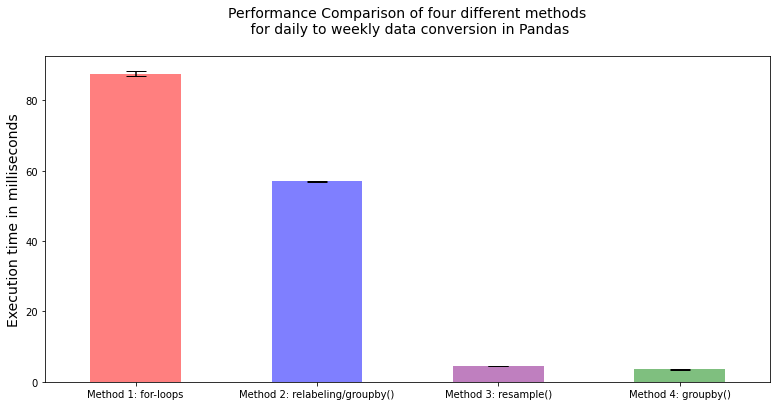

In [32]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(13,6))
methods_performance['Mean'].plot(kind = 'bar', yerr=methods_performance['Std'], align='center',
                                alpha=0.5, color=['red', 'blue', 'purple', 'green'], ecolor='black', capsize=10)
plt.xticks(rotation = 0)
plt.ylabel('Execution time in milliseconds', fontsize=14);
plt.title('Performance Comparison of four different methods\n for daily to weekly data conversion in Pandas\n', 
          fontsize=14)
plt.show()

Thank you for reading, 

Diana